# Gold Price Prediction for 20 Years (monthly)

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_squared_log_error, \
                            r2_score, mean_absolute_error

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.random import set_seed
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

set_seed(455)
np.random.seed(455)

In [21]:
def evaluate_model(test, predicted):
    rmse = np.sqrt(mean_squared_error(test, predicted))
    mae = mean_absolute_error(test, predicted)
    r2 = r2_score(test, predicted)
    msle = mean_squared_log_error(test, predicted)
    mape = np.mean(np.abs((test - predicted) / test)) * 100

    print(f"The root mean squared error (RMSE) is {rmse:.2f}")
    print(f"The Mean Absolute Error (MAE) is {mae:.2f}")
    print(f"The R-squared (R²) score is {r2:.4f}\n")
    print(f"The Mean Squared Logarithmic Error (MSLE) is {msle:.6f}")
    print(f"The Mean Absolute Percentage Error (MAPE) is {mape:.2f}%.")

In [36]:
def plot_predictions(test, predicted):
    plt.figure(figsize=(16, 9))
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title("Gold Price Prediction")
    plt.xlabel("Time")
    plt.ylabel("Gold Price ($)")
    plt.legend()
    plt.show()

In [23]:
dataset = pd.read_csv('data/gold/monthly.csv', parse_dates=['Date'], index_col = "Date")

In [24]:
dataset.sort_index(inplace=True)

In [25]:
dataset

,Price
Date,
1833-01-01,18.93
1833-02-01,18.93
1833-03-01,18.93
1833-04-01,18.93
1833-05-01,18.93
...,...
2024-06-01,2326.44
2024-07-01,2398.20
2024-08-01,2470.15


In [26]:
tstart = "1833-01-01"
tend = "2004-10-01"

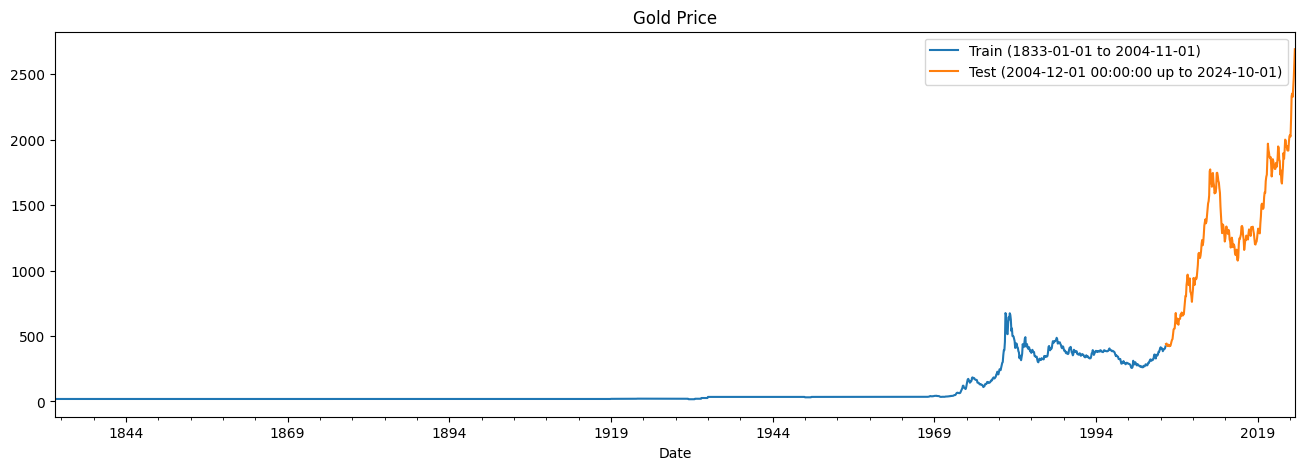

In [27]:
def train_test_plot(dataset, tstart, tend):
    tend_next = pd.to_datetime(tend) + pd.DateOffset(months=1)

    dataset.loc[tstart:tend, "Price"].plot(figsize=(16, 5), legend=True)
    dataset.loc[tend_next:, "Price"].plot(figsize=(16, 5), legend=True)

    plt.legend([f"Train ({tstart} to {tend_next.date()})", f"Test ({tend_next.date() + pd.DateOffset(months=1)} up to 2024-10-01)"])
    plt.title("Gold Price")
    plt.show()

train_test_plot(dataset, tstart, tend)

In [28]:
def train_test_split(dataset, tstart, tend):
    tend_next = pd.to_datetime(tend) + pd.Timedelta(days=1)

    train = dataset.loc[tstart:tend, "Price"].values
    test = dataset.loc[tend_next:, "Price"].values
    return train, test

training_set, test_set = train_test_split(dataset, tstart, tend)

In [29]:
sc = MinMaxScaler()
training_set = training_set.reshape(-1, 1)
training_set_scaled = sc.fit_transform(training_set)

In [30]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

n_steps = 120  # Number of time steps to look back
features = 1

X_train, y_train = split_sequence(training_set_scaled, n_steps)

# Reshape for GRU model
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], features)

In [31]:
# The LSTM architecture
model_gru = Sequential()
model_gru.add(GRU(units=256, activation="tanh", input_shape=(n_steps, features)))
model_gru.add(Dense(units=1))
# Compiling the model
model_gru.compile(optimizer="RMSprop", loss="mean_squared_error")

model_gru.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 256)               198912    
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 199,169
Trainable params: 199,169
Non-trainable params: 0
_________________________________________________________________


In [32]:
early_stop = EarlyStopping(monitor="loss", patience=10, restore_best_weights=True)

checkpoint = ModelCheckpoint(
    "default_gru.keras",  # File to save the model
    monitor="loss",  # Metric to track (e.g., validation loss)
    save_best_only=True,  # Save only if the model improves
    mode="min",  # Save when 'loss' decreases
    verbose=1  # Print messages when saving
)

# increase epochs to 50 or 100
model_gru.fit(X_train, y_train, epochs=25, batch_size=32, callbacks=[early_stop, checkpoint], verbose=1)

Epoch 1/25
61/61 [==============================] - ETA: 0s - loss: 0.0035
Epoch 1: loss improved from inf to 0.00347, saving model to default_gru.keras
61/61 [==============================] - 14s 214ms/step - loss: 0.0035
Epoch 2/25
61/61 [==============================] - ETA: 0s - loss: 7.8397e-04
Epoch 2: loss improved from 0.00347 to 0.00078, saving model to default_gru.keras
61/61 [==============================] - 16s 264ms/step - loss: 7.8397e-04
Epoch 3/25
61/61 [==============================] - ETA: 0s - loss: 7.3762e-04
Epoch 3: loss improved from 0.00078 to 0.00074, saving model to default_gru.keras
61/61 [==============================] - 18s 294ms/step - loss: 7.3762e-04
Epoch 4/25
61/61 [==============================] - ETA: 0s - loss: 6.8977e-04
Epoch 4: loss improved from 0.00074 to 0.00069, saving model to default_gru.keras
61/61 [==============================] - 19s 310ms/step - loss: 6.8977e-04
Epoch 5/25
61/61 [==============================] - ETA: 0s - loss: 

In [33]:
dataset_total = dataset.loc[:, "Price"]
inputs = dataset_total[len(dataset_total) - len(test_set) - n_steps :].values
inputs = inputs.reshape(-1, 1)
#scaling
inputs = sc.transform(inputs)

# Split into samples
X_test, y_test = split_sequence(inputs, n_steps)
# reshape
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], features)
#prediction
predicted_stock_price = model_gru.predict(X_test)
#inverse transform the values
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

8/8 [==============================] - 1s 55ms/step


In [34]:
evaluate_model(test_set, predicted_stock_price)

The root mean squared error (RMSE) is 79.72
The Mean Absolute Error (MAE) is 59.81
The R-squared (R²) score is 0.9713

The Mean Squared Logarithmic Error (MSLE) is 0.003075
The Mean Absolute Percentage Error (MAPE) is 49.07%.


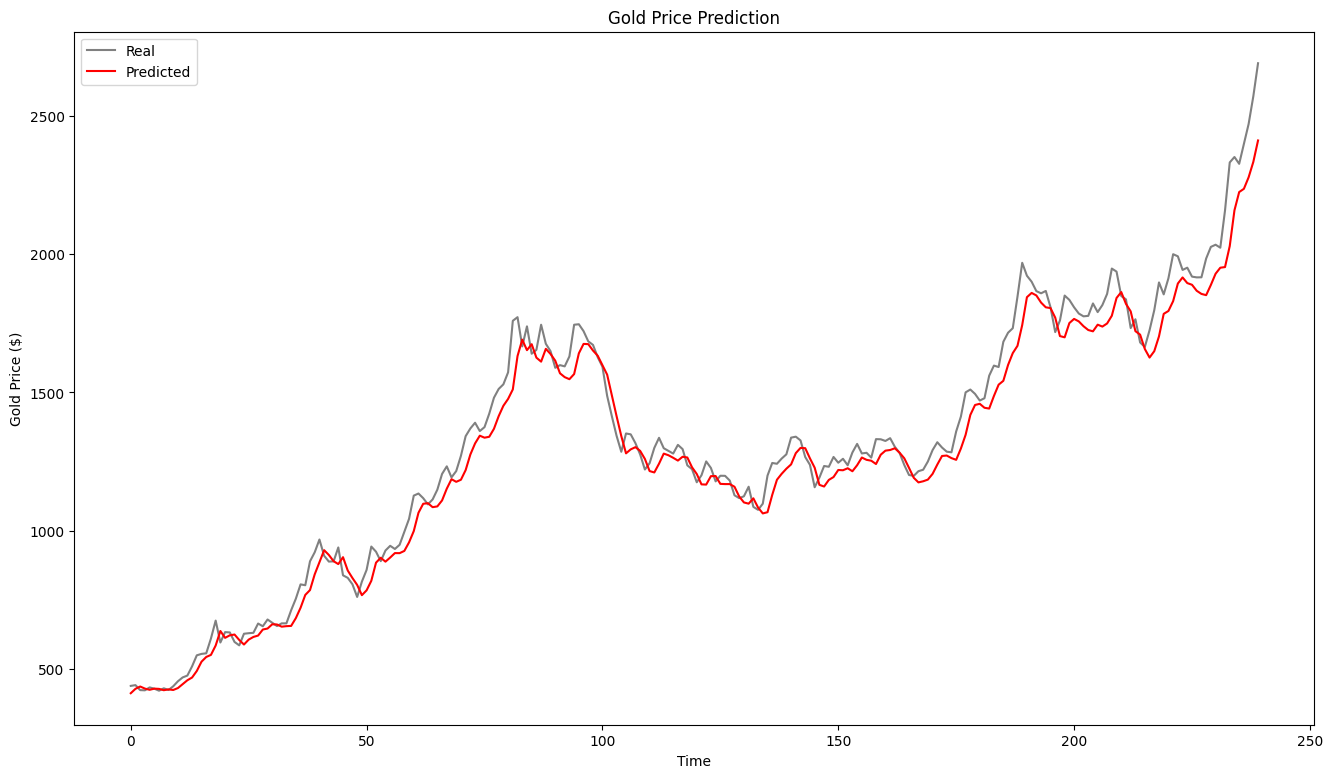

In [37]:
plot_predictions(test_set, predicted_stock_price)